# PyDMD

## Tutorial 14: Demonstrating the optDMD and BOP-DMD

In this tutorial we go over the Bagging-Optimized Dynamic Mode Decomposition (BOP-DMD) and Optimized Dynamic Mode Decomposition (optDMD) methods. The tutorial is set up exactly as in [Tutorial 2](https://github.com/mathLab/PyDMD/blob/master/tutorials/tutorial2/tutorial-2-adv-dmd.ipynb) to provide a direct comparison between methods.

Note, that there is a namespace conflict with `optimized DMD`. The optDMD we refer to in this tutorial is the one by Ashkham and Kutz (2018). We differentiate the optDMD of Ashkham and Kutz from the exact DMD with the optimal closed-form solution from Heas and Herzet (2016).

The optDMD and BOP-DMD are effectively the same method, but with the BOP-DMD implementing a statistical bagging of optDMD fits and aggregating the results.

1) optDMD: Provides an optimized framework for solving the DMD regressions that may come from unevenly spaced time snapshots.

2) The BOP-DMD takes advantage of this property and solves the DMD using statistical bagging (i.e., randomly selected ensembles) for constructing the optDMD.

The advantages of the combined BOP-DMD are: 
- The additional ability to provide uncertainty estimates in the solutions, including uncertainty in the spatial modes, eigenvalues, and amplitudes
- More robustly fitting noisy data.

## Methods compared

Three methods are compared:
1) The total least-squares DMD with optimal amplitudes.
2) The optimized DMD from Askham and Kutz (2018; note the namespace conflict with Heas and Herzet's (2016) optimal solution!)
3) The BOP-DMD
 
Method (1) comes directly from Tutorial 2.

## Citations

- **optimized Dynamic Mode Decomposition (optDMD)**: Askham, T., & Kutz, J. N. (2018). Variable projection methods for an optimized dynamic mode decomposition. SIAM Journal on Applied Dynamical Systems, 17(1), 380–416. https://doi.org/10.1137/M1124176

- **Bagging, Optimized Dynamic Mode Decomposition (BOP-DMD)**: Sashidhar, D., & Kutz, J. N. (2022). Bagging, optimized dynamic mode decomposition for robust, stable forecasting with spatial and temporal uncertainty quantification. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2229). https://doi.org/10.1098/rsta.2021.0199

- **optimal closed-form solution to the exact DMD**: Héas, P., & Herzet, C. (2022). Low-Rank Dynamic Mode Decomposition: An Exact and Tractable Solution. Journal of Nonlinear Science, 32(1). https://doi.org/10.1007/s00332-021-09770-w

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD
from pydmd.bopdmd import BOPDMD

In [2]:
def relative_error(x_est, x_true):
    """Helper function for calculating the relative error."""
    return np.linalg.norm(x_est - x_true) / np.linalg.norm(x_true)

## Setting up the toy data

The toy data is exactly the same as in tutorial 2 to provide a direct comparison. The example is a single two-dimensional spatial mode modified by a temporal oscillation with period of 4 that decays towards zero amplitude with time.

Two versions of the data are created as a convenience: a 3d array of 2d spatial snapshots along a time dimension and a 2d array where the spatial dimensions have been flattened down. This is necessary because PyDMD classes expect data of the form `len(samples) x len(time)`.

The data are subdivided into training data and forecast data, as this represents real world use cases for fitting and forecasting. 

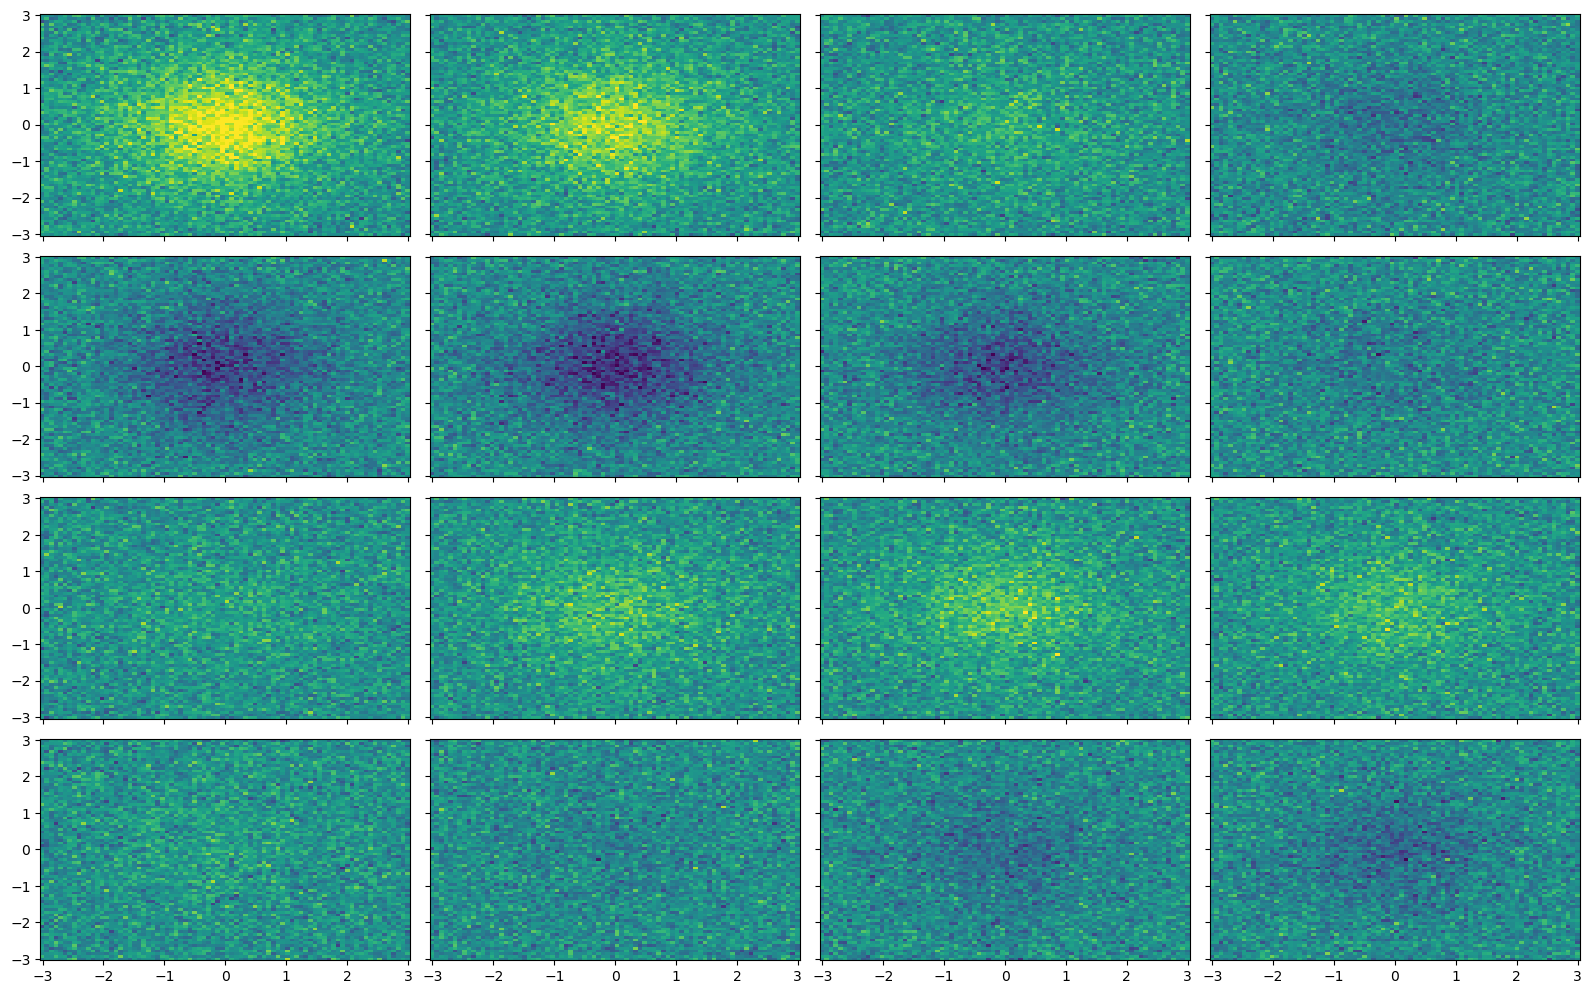

In [3]:
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

# Set the random seed for reproducibility
seed = 1
# The noise amplitude matches the noise amplitude in tutorial 2.
sigma = 0.4

time_forecast = np.arange(6 + 0.4, 18 + 0.4, 0.4)
time = np.arange(0, 6 + 0.4, 0.4)
num_time_samples = len(time)
true_eigenvalues = (-0.115 - 1j) * np.pi / 2

spatial_modes = 2 / np.cosh(x1grid) / np.cosh(x2grid)
data_clean = spatial_modes[:, :, np.newaxis] * np.exp(true_eigenvalues * time)
data_forecast = spatial_modes[:, :, np.newaxis] * np.exp(
    true_eigenvalues * time_forecast
)

rng = np.random.default_rng(seed)
noise = rng.normal(
    0, sigma, (x1grid.shape[0], x1grid.shape[1], num_time_samples)
)
snapshots_2d = data_clean + noise

# PyDMD expects the data to be 2-dimensional, with shape len(space) x len(time)
snapshots_1d = snapshots_2d.reshape(
    x1grid.shape[0] * x1grid.shape[1], num_time_samples
)

fig, axes = plt.subplots(4, 4, figsize=(16, 10), sharex=True, sharey=True)
for ntime, _ in enumerate(time):
    ax = axes.flatten()[ntime]
    ax.pcolor(x1grid, x2grid, snapshots_2d[:, :, ntime].real, vmin=-2, vmax=2)
fig.tight_layout()

plt.show()

## Fitting and forecasting

All methods are fit through the same syntax, but vary in how the forecasted period is represented.

To reiterate, PyDMD objects expect data of the shape len(space) x len(time), so we have to use the data in which the spatial dimensions collapsed down to a single dimension. After fitting the training data, the data are then forecasted to the forecast period.

In [4]:
optdmd = BOPDMD(svd_rank=1, num_trials=0)
bopdmd = BOPDMD(svd_rank=1, num_trials=100)
dmd = DMD(svd_rank=1, tlsq_rank=2, exact=True, opt=True)

optdmd.fit(snapshots_1d, time)
bopdmd.fit(snapshots_1d, time)
dmd.fit(snapshots_1d)

# Recovering the reconstruction uncertainty is most straight forward using
# the `forecast` method.
reconstruction_mean, reconstruction_variance = bopdmd.forecast(time)

# Forecast the forecast period with BOP-DMD
forecast_mean, forecast_variance = bopdmd.forecast(time_forecast)

# It is necessary to deepcopy the dmd object when generating
# the dmd forecast to avoid overwriting the reconstruction.
dmd_forecast = copy.deepcopy(dmd)
dmd_forecast.dmd_time["t0"] = dmd.dmd_time["tend"] + dmd.dmd_time["dt"]
dmd_forecast.dmd_time["tend"] *= 3

The optDMD and BOP-DMD are rooted in the same class. For this generalized class:
- The number of trials, `num_trials`, specifies the number of ensemble members to use in the bagging step of the BOP-DMD.
- The optDMD is the default method when calling BOP-DMD as the 'num_trials' keyword defaults to 0.
- `trial_size` determines how much of the total data is used when constructing each ensemble member.

For the DMD we follow Tutorial 2 to provide a direct comparison between methods.

Finally, the optDMD/BOP-DMD methods do not need to have evenly spaced data. e.g., randomly chosen snapshots could be dropped (for example representing a case where observational instruments fail) and the data could still be fit.

In [5]:
optdmd_bad_data_demo = BOPDMD(svd_rank=1, num_trials=0)
# Drop time steps 5 and 7 to demonstrate not needing uniformly spaced data.
index_to_keep = np.array([0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15])
optdmd_bad_data_demo.fit(snapshots_1d[:, index_to_keep], time[index_to_keep])

# Demonstrate the robustness of the fit using the error in eigenvalues
re = relative_error(optdmd_bad_data_demo.eigs, true_eigenvalues)

print("Eigenvalue error in bad data demonstration = {:.4f}".format(re))

Eigenvalue error in bad data demonstration = 0.0004


The optDMD is quite robust in regards to unevenly spaced data.

## Evaluations

### Eigenvalues and Time Dynamics

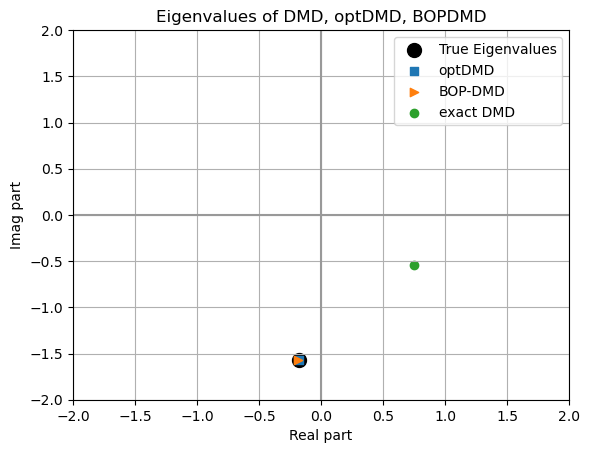

In [6]:
fig, ax = plt.subplots(1, 1)
ax.scatter(
    true_eigenvalues.real,
    true_eigenvalues.imag,
    100,
    label="True Eigenvalues",
    color="k",
)
ax.scatter(
    np.real(optdmd.eigs), np.imag(optdmd.eigs), label="optDMD", marker="s"
)
ax.scatter(
    np.real(bopdmd.eigs), np.imag(bopdmd.eigs), label="BOP-DMD", marker=">"
)
ax.scatter(np.real(dmd.eigs), np.imag(dmd.eigs), label="exact DMD")
ax.set_xlabel("Real part")
ax.set_ylabel("Imag part")
ax.legend()
ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)
ax.grid()
ax.axhline(0, color="0.6")
ax.axvline(0, color="0.6")
ax.set_title("Eigenvalues of DMD, optDMD, BOPDMD")
plt.show()

The optDMD and BOP-DMD recover the true eigenvalues. It is unclear what is driving the difference in eigenvalues between the DMD methods.

One of the main advantages of the BOP-DMD is the ability to provide uncertainties on the fit. Here, the eigenvalue (and thus time dyanmic) uncertainties can be recovered.


In [7]:
print(
    "Uncertainty in the BOPDMD eigenvalues={:.02f}".format(
        bopdmd.eigenvalues_std[0]
    )
)

# Compare to the eigenvalue error
re = relative_error(bopdmd.eigs, true_eigenvalues)
print("Error in the BOPDMD eigenvalues={:.03f}".format(re))

Uncertainty in the BOPDMD eigenvalues=0.01
Error in the BOPDMD eigenvalues=0.001


### Time Dynamics

All DMD classes recover the time dynamics, but the DMD appears to have a phase offset. In contrast, the BOP-DMD and optDMD recover these dyanmics almost exactly. The time dynamics can be recovered directly by normalizing the `dyanmics` using the `amplitudes`.

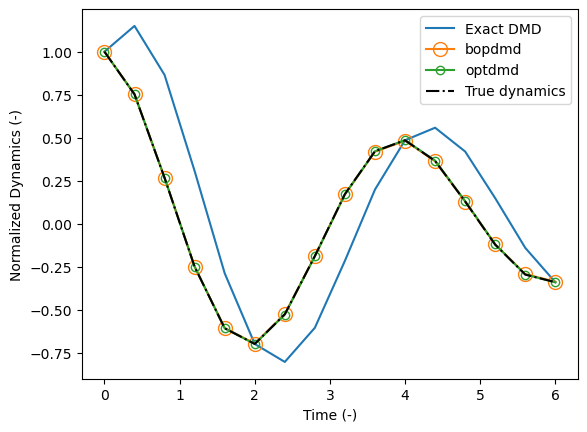

In [8]:
plt.plot(time, dmd.dynamics.real.T / dmd.amplitudes.real, label="Exact DMD")
# We have to carefully format the markers since the BOP-DMD, optDMD,
# and true data are hard to distinguish otherwise.
plt.plot(
    time,
    bopdmd.dynamics.real.T / bopdmd.amplitudes.real,
    marker="o",
    markersize=10,
    markerfacecolor="none",
    label="bopdmd",
)
plt.plot(
    time,
    optdmd.dynamics.real.T / optdmd.amplitudes.real,
    marker="o",
    markerfacecolor="none",
    label="optdmd",
)
plt.plot(
    time, np.exp(true_eigenvalues * time).real, "k-.", label="True dynamics"
)
plt.legend()
plt.gca().set_xlabel("Time (-)")
plt.gca().set_ylabel("Normalized Dynamics (-)")
plt.show()

The average time dynamics of the entire system can also be recovered by averaging the spatial modes for each time step. This roughly corresponds to the two-dimensional integral from Tutorial 2. The forecasted period is also examined.

The optDMD is neglected here for visual clarity.

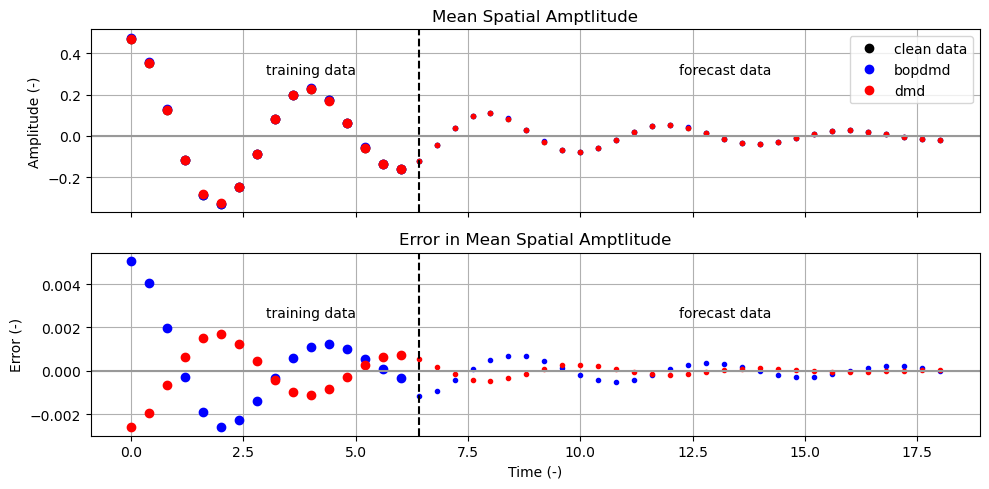

In [9]:
# This is a two part plot.
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

# The upper subplot shows the spatial means.
ax = axes[0]

# Plot the original data without noise for both the training
# and forecast periods.
ax.plot(
    time,
    data_clean.mean(axis=(0, 1)).real,
    label="clean data",
    color="k",
    marker="o",
    ls="None",
)
ax.plot(
    time_forecast,
    data_forecast.mean(axis=(0, 1)).real,
    color="k",
    marker=".",
    ls="None",
)

# Plot the BOP-DMD reconstruction and forecast.
ax.plot(
    time,
    bopdmd.reconstructed_data.mean(axis=0).real,
    label="bopdmd",
    color="b",
    marker="o",
    ls="None",
)
ax.plot(
    time_forecast,
    forecast_mean.mean(axis=0).real,
    color="b",
    marker=".",
    ls="None",
)

# Plot the exact DMD reconstruction and forecast.
ax.plot(
    time,
    dmd.reconstructed_data.mean(axis=0).real,
    label="dmd",
    color="r",
    marker="o",
    ls="None",
)
ax.plot(
    time_forecast,
    dmd_forecast.reconstructed_data.mean(axis=0).real,
    color="r",
    marker=".",
    ls="None",
)

# Format the subplot.
ax.legend()
ax.set_ylabel("Amplitude (-)")
ax.set_title("Mean Spatial Amptlitude")
ax.axhline(0, color="0.6")
ax.grid()

# Indicate the training and forecast intervals.
ax.axvline(time_forecast[0], ls="--", color="k")
ax.text(np.mean(time_forecast), 0.3, "forecast data", transform=ax.transData)
ax.text(np.mean(time), 0.3, "training data", transform=ax.transData)

# The lower subplots shows the error in the spatial means.
ax = axes[1]

# Spatial mean error in the BOP-DMD.
ax.plot(
    time,
    bopdmd.reconstructed_data.mean(axis=0).real
    - data_clean.mean(axis=(0, 1)).real,
    color="b",
    marker="o",
    ls="None",
)
ax.plot(
    time_forecast,
    forecast_mean.mean(axis=0).real - data_forecast.mean(axis=(0, 1)).real,
    color="b",
    marker=".",
    ls="None",
)

# Spatial mean error in the exact DMD.
ax.plot(
    time,
    dmd.reconstructed_data.mean(axis=0).real
    - data_clean.mean(axis=(0, 1)).real,
    color="r",
    marker="o",
    ls="None",
)
ax.plot(
    time_forecast,
    dmd_forecast.reconstructed_data.mean(axis=0).real
    - data_forecast.mean(axis=(0, 1)).real,
    color="r",
    marker=".",
    ls="None",
)

# Format the subplot.
ax.set_ylabel("Error (-)")
ax.set_xlabel("Time (-)")
ax.set_title("Error in Mean Spatial Amptlitude")
ax.axhline(0, color="0.6")
ax.grid()


# Indicate the training and forecast intervals.
ax.axvline(time_forecast[0], ls="--", color="k")
ax.text(np.mean(time_forecast), 0.0025, "forecast data", transform=ax.transData)
ax.text(np.mean(time), 0.0025, "training data", transform=ax.transData)

fig.tight_layout()
plt.show()

Both the BOP-DMD and DMD recover the training and forecasted data with high fidelity, which can be quantified:

In [10]:
re = relative_error(
    dmd_forecast.reconstructed_data.reshape(
        x1grid.shape[0], x1grid.shape[1], len(time_forecast)
    ),
    data_forecast,
)
print("Relative Error of the DMD forecast: {:0.2f}".format(re))

Relative Error of the DMD forecast: 0.25


In [11]:
re = relative_error(
    forecast_mean.reshape(x1grid.shape[0], x1grid.shape[1], len(time_forecast)),
    data_forecast,
)
print("Relative Error of the BOP-DMD forecast: {:0.2f}".format(re))

Relative Error of the BOP-DMD forecast: 0.23


The BOP-DMD just barely outperforms the DMD when evaluating a forecasted period. Note: the relative improvement depends on the level of noise and the DMD can even out perform the BOP-DMD in some cases.

### Spatial Modes

In most real-world cases we don't have the actual underlying modes to compare to. However, with the toy data we can see how well the spatial mode was recovered.

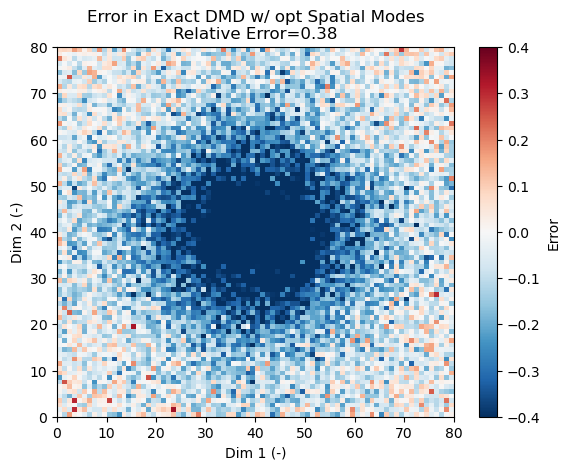

In [12]:
dmd_spatial_modes = dmd.modes.reshape(x1grid.shape).real * dmd.amplitudes.real

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(
    dmd_spatial_modes - spatial_modes, vmin=-sigma, vmax=sigma, cmap="RdBu_r"
)
cbar = fig.colorbar(c)
cbar.set_label("Error")
ax.set_title(
    "Error in Exact DMD w/ opt Spatial Modes\nRelative Error={:.2f}".format(
        relative_error(dmd_spatial_modes, spatial_modes)
    )
)
ax.set_ylabel("Dim 2 (-)")
ax.set_xlabel("Dim 1 (-)")
plt.show()

The DMD has some issues recovering the spatial modes, as the errors exhibit a spatial bias.

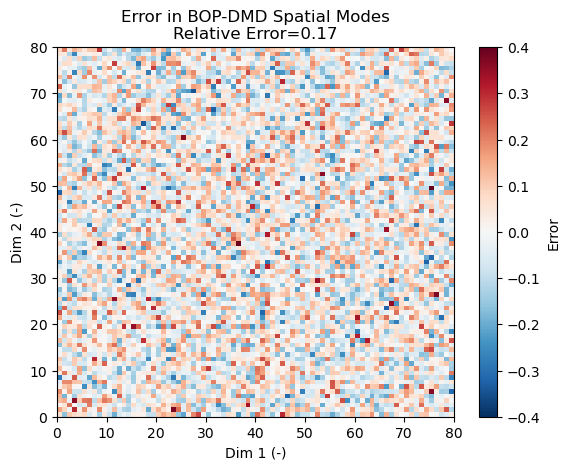

In [13]:
bopdmd_spatial_modes = (
    bopdmd.modes.reshape(x1grid.shape).real * bopdmd.amplitudes.real
)

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(
    bopdmd_spatial_modes - spatial_modes, vmin=-sigma, vmax=sigma, cmap="RdBu_r"
)
cbar = fig.colorbar(c)
cbar.set_label("Error")
ax.set_title(
    "Error in BOP-DMD Spatial Modes\nRelative Error={:.2f}".format(
        relative_error(bopdmd_spatial_modes, spatial_modes)
    )
)
ax.set_ylabel("Dim 2 (-)")
ax.set_xlabel("Dim 1 (-)")
plt.show()

The BOP-DMD spatial mode error is effectively flat, with just random white noise corrupting the spatial modes. The relative error in the spatial modes is slightly smaller than for the DMD.

### Spatial Mode uncertainty

One of the major features of BOP-DMD is the ability to quantify uncertainty in the temporal and spatial modes. The below shows the uncertainty in the spatial modes.

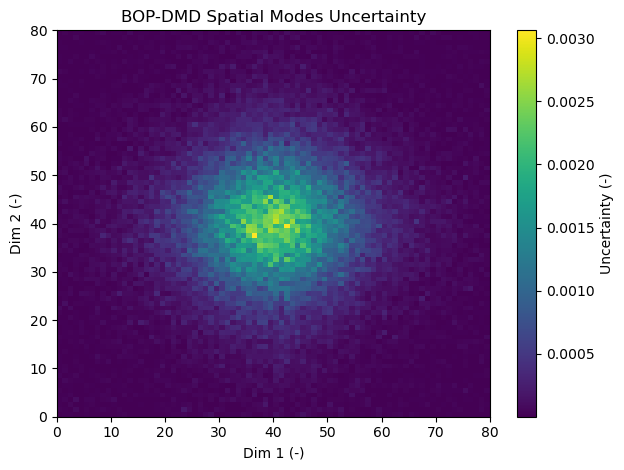

In [14]:
fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(
    reconstruction_variance.mean(axis=1).reshape(
        (x1grid.shape[0], x1grid.shape[1])
    )
)
cbar = fig.colorbar(c)
cbar.set_label("Uncertainty (-)")
ax.set_title("BOP-DMD Spatial Modes Uncertainty")
ax.set_ylabel("Dim 2 (-)")
ax.set_xlabel("Dim 1 (-)")
fig.tight_layout()
plt.show()

The uncertainty is largest in the center of the spatial domain (although the magnitude of the uncertainty is perhaps a bit unbelievable given how noisy the system is). However, it is worth nothing that the uncertainty is much smaller than the error, potentially revealing an underestimate of the true uncertainty in the system.

## Parting comments

The BOP-DMD and optDMD were designed for fitting DMDs to noisy data or data with unevenly spaced data points. But, there are a number of other methods for handling noisy data with DMDs. In this tutorial we examined the exact DMD using the `tlsq_rank` keyword.

1) How do other methods designed to handle noisy data (e.g., the forward-backward DMD) compare to the BOP-DMD and the exact DMD with the `tlsq_rank` keyword?

2) What happens if you change the noise? Consider types of noise commonly present in real data sets such as noise that is not uniform in time or space or non-white noise.